In [1]:
from config import *
import os
from glob import glob
import sys
sys.path.append("..")

import numpy as np
import pickle

import matplotlib.pyplot as plt

from overall import load_file

In [119]:
exp_type = "celeba"

if exp_type == "adult":
    checkpoint = "xgb-adult"
    noise_frac = 0.5
elif exp_type == "celeba":
    checkpoint = "resnet50"
    noise_frac = 1.0

# pos = glob(os.path.join(ckpt_dir, f"sup-wise/{checkpoint}-noise-{noise_frac:.2f}-support-*pkl"))

In [120]:
from utils import get_support_bucket

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, LeaveOneOut

from sklearn.metrics import accuracy_score, f1_score

In [122]:
from sklearn.tree import plot_tree
from sklearn.base import BaseEstimator, ClassifierMixin

In [123]:
# with open("buckets.pkl", "rb") as f:
#     buckets = pickle.load(f)

from distill import Result
with open(f"{checkpoint}-results-v2.pkl", "rb") as f:
    results = pickle.load(f)

In [124]:
window = 5
sup_thresh = {
    "adult": 1.,
    "celeba": 0.5, # for celeba we do not take cases w/ support > 0.5 since only very few subgroups can be analyzed
}[exp_type]

buckets = { "pos": {}, "neg": []}
for r in results:
    if r.window != window or r.metric != "accuracy":
        continue
    bucket = r.support
    if r.gt == "pos":
        if r.support[0] > sup_thresh:
            continue # skip
        if bucket not in buckets["pos"]:
            buckets["pos"][bucket] = []
        buckets["pos"][bucket].append(np.vstack([r.delta, r.tstat]))
    elif r.gt == "neg":
        buckets["neg"].append(np.vstack([r.delta, r.tstat]))
buckets["pos"] = { k: np.stack(v) for k, v in buckets["pos"].items() }
buckets["neg"] = np.stack(buckets["neg"])
# buckets["pos"] = { r.support[0]: np.vstack([r.delta, r.tstat]) for r in results if r.gt == "pos" and r.window == window }
# buckets["neg"] = [ np.vstack([r.delta, r.tstat]) for r in results if r.gt == "neg" and r.window == window ]

In [125]:
basedir_summary = "../overall_summary_buckets_results"

In [126]:
with open(f"{basedir_summary}/summary_bucket_results_overall_{exp_type}_may_21.pkl", "rb") as f:
    summary = pickle.load(f)
if exp_type == "adult":
    # with open("../summary_bucket_results_overall_adult.pkl", "rb") as f:
    pass
elif exp_type == "celeba":
    # with open("../summary_bucket_results_overall_celeba__all_new_methods_kswin.pkl", "rb") as f:
    #     summary = pickle.load(f)

    # for celeba, we do not take cases w/ support > 0.5 since only very few subgroups can be analyzed
    # (adult has more subgroups with high support)
    for metric in ["accuracies", "precisions", "recalls", "f1s", "fprs", "fnrs"]:
        for method in summary[metric]:
            summary[metric][method] = summary[metric][method][:-2] # hardcoded -2, removes supports > 0.5
    summary["supports"] = summary["supports"][:-2]

In [127]:
# # for mat in summary['cm']['fet']:
# #      tn, fp, fn, tp = mat
# #      tp, tn = fn, fp

# summary['accuracies']['fet'] = [ (tp + tn) / (tp + tn + fp + fn) for fp, tn, tp, fn in summary['cm']['fet'] ]
# summary['precisions']['fet'] = [ tp / (tp + fp) for                  fp, tn, tp, fn in summary['cm']['fet'] ]
# summary['recalls']['fet']    = [ tp / (tp + fn) for                  fp, tn, tp, fn in summary['cm']['fet'] ]
# summary['f1s']['fet']        = [ 2 * tp / (2 * tp + fp + fn) for     fp, tn, tp, fn in summary['cm']['fet'] ]
# summary['fprs']['fet']        = [ fp / (fp + tn) for                  fp, tn, tp, fn in summary['cm']['fet'] ]
# summary['fnrs']['fet']        = [ fn / (fn + tp) for                  fp, tn, tp, fn in summary['cm']['fet'] ]

In [128]:
from sklearn.metrics import confusion_matrix

In [129]:

class Threshold(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold, gt=True):
        self.threshold = threshold
        self.gt = gt
    
    def fit(self, X, y):
        pass

    def predict(self, X):
        if self.gt:
            return (X > self.threshold).astype(int).flatten()
        else:
            return (X < self.threshold).astype(int).flatten()
    
    def fit_predict(self, X, y):
        self.fit(X, y)
        return self.predict(X)

buckets_list = sorted(buckets["pos"].keys(), key=lambda x: x[0])
plotted = [False] * len(buckets_list)

plot_trees = False
plot_distrib = False

indicators = ["tstat", "delta"]

scores_acc = {}
scores_f1 = {}
scores_fpr = {}
scores_fnr = {}
raw_scores = {}

max_exp = 50

tau_t = 5
tau_delta = {"adult": -0.4, "celeba": -0.25 }[exp_type]

y_trues = { ind: [] for ind in indicators }
y_preds = { ind: [] for ind in indicators }

for indicator in indicators:
    if indicator == "tstat":
        # models = [ DecisionTreeClassifier(max_depth=1), LogisticRegression() ] + [ Threshold(i, gt=True) for i in [5] ]
        # model_names = [ "DT", "LR", r"$\tau > 5$" ]
        models = [ Threshold(i, gt=True) for i in [tau_t] ]
        model_names = [ fr"$\tau_t > {tau_t}$" ]
        # q = [100] # max
        func = np.max
    elif indicator == "delta":
        # models = [ DecisionTreeClassifier(max_depth=1), LogisticRegression() ] + [ Threshold(i, gt=False) for i in [-0.4 ]]
        # model_names = [ "DT", "LR", r"$\tau < -0.4$" ]
        models = [ Threshold(i, gt=False) for i in [tau_delta]]
        model_names = [fr"$\tau_\Delta < {tau_delta}$" ]
        # q = [0] # min
        func = np.min
    else:
        raise ValueError("Invalid indicator")
    
    scores_acc[indicator] = { model_name: [] for model_name in model_names }
    scores_f1[indicator] = { model_name: [] for model_name in model_names }
    scores_fpr[indicator] = { model_name: [] for model_name in model_names }
    scores_fnr[indicator] = { model_name: [] for model_name in model_names }
    raw_scores[indicator] = {}

    if plot_distrib:
        fig, ax = plt.subplots(5, 4, figsize=(20, 20))

    ind_pos = 0 if indicator == "delta" else 1

    for model, model_name in zip(models, model_names):
        for bucket_pos, bucket in enumerate(buckets_list):
            X = np.vstack([
                # np.percentile(buckets["pos"][bucket][:, ind_pos], q, axis=1).T,
                # np.percentile(buckets["neg"][:len(buckets["pos"][bucket]), ind_pos], q, axis=1).T
                func(buckets["pos"][bucket][:max_exp, ind_pos], axis=1, where=buckets["pos"][bucket][:max_exp, ind_pos]<1e6, initial=0).reshape(-1,1),
                func(buckets["neg"][:len(buckets["pos"][bucket]), ind_pos], axis=1, where=buckets["neg"][:min(max_exp,len(buckets["pos"][bucket])), ind_pos]<1e6, initial=0).reshape(-1,1)
            ])
            # y = np.array([ 1 ] * len(buckets["pos"][bucket]) + [ 0 ] * len(buckets["neg"]))
            y = np.array([ 1 ] * min(max_exp, len(buckets["pos"][bucket])) + [ 0 ] * min(max_exp, len(buckets["pos"][bucket])))

            if not plotted[bucket_pos] and plot_distrib:
                plotted[bucket_pos] = True
                
                ax[bucket_pos // 4, bucket_pos % 4].hist(X[y==0, 0], bins=100, alpha=.5)
                ax[bucket_pos // 4, bucket_pos % 4].hist(X[y==1, 0], bins=100, alpha=.5)
                # ax[bucket_pos // 4, bucket_pos % 4].axvline(5, c='r', ls='--')

            y_pred = model.predict(X)

            y_trues[indicator].append(y)
            y_preds[indicator].append(y_pred)
            
            # y_pred = cross_val_predict(model, X, y, cv=10)
            scores_acc[indicator][model_name].append(accuracy_score(y, y_pred))
            scores_f1[indicator][model_name].append(f1_score(y, y_pred))
            
            tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
            scores_fpr[indicator][model_name].append(fp / (fp + tn))
            scores_fnr[indicator][model_name].append(fn / (fn + tp))

            raw_scores[indicator][bucket] = y, X[:, 0]


            if model_name == "DT" and plot_trees:
                model_full = model.fit(X, y)
                plt.figure()
                plot_tree(model_full)
                
            model_full = model.fit(X, y)

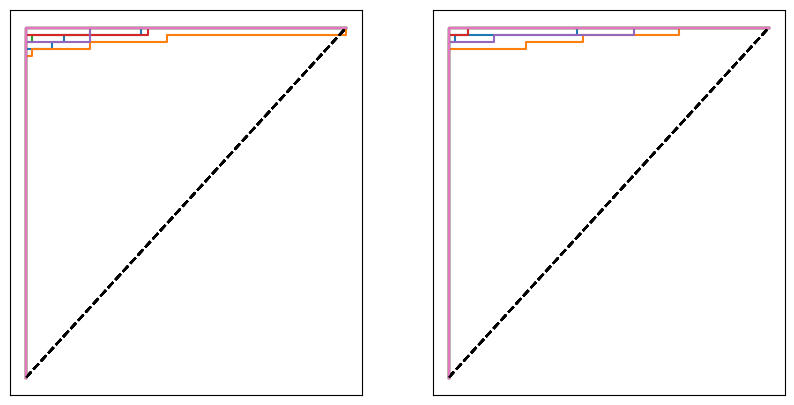

In [130]:
# fig, ax = plt.subplots(5, 5, figsize=(8, 8))
from sklearn.metrics import roc_auc_score

fig, ax = plt.subplots(1, 2, figsize=(10,5))

# roc curves
from sklearn.metrics import roc_curve

aucs = {}
best_thresh = {}
for i, indicator in enumerate(indicators):
    aucs[indicator] = []
    best_thresh[indicator] = []
    for bucket_pos, bucket in enumerate(buckets_list):
        y, X = raw_scores[indicator][bucket]
        if indicator == "delta":
            X = -X
        fpr, tpr, thresh = roc_curve(y, X)
        auc = roc_auc_score(y, X)
        aucs[indicator].append(auc)
        

        j_statistic = tpr - fpr
        optimal_threshold_index = np.argmax(j_statistic)
        # [bucket_pos // 4, bucket_pos % 4]
        ax[i].plot(fpr, tpr)
        ax[i].plot([0, 1], [0, 1], c='k', ls='--')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        best_thresh[indicator].append(thresh[optimal_threshold_index])

with open(f"best_thresh_{exp_type}.pkl", "wb") as f:
    pickle.dump((best_thresh, buckets_list), f)

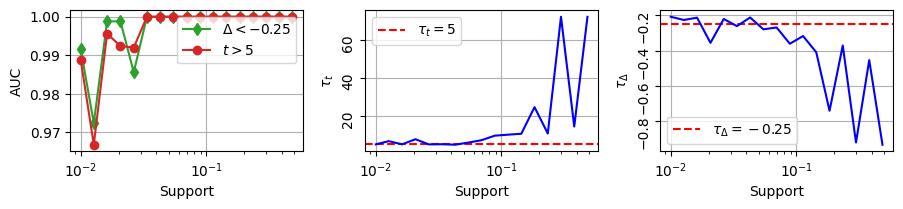

In [131]:
fig, ax = plt.subplots(1, 3, figsize=(9,2))
# tight layout
plt.tight_layout()

ax[0].plot([ b[0] for b in buckets_list ], aucs["delta"], label=rf"$\Delta < {tau_delta}$", marker='d', c='tab:green')
ax[0].plot([ b[0] for b in buckets_list ], aucs["tstat"], label=rf"$t > {tau_t}$", marker='o', c='tab:red')
ax[0].set_ylabel("AUC")

ax[1].axhline(tau_t, c='r', ls='--', label=rf"$\tau_{{t}} = {tau_t}$")
ax[2].axhline(tau_delta, c='r', ls='--', label=rf"$\tau_{{\Delta}} = {tau_delta}$")
ax[1].plot([ b[0] for b in buckets_list ], best_thresh["tstat"], c='b')
ax[2].plot([ b[0] for b in buckets_list ], [ -d for d in best_thresh["delta"]], c='b')

ax[1].set_ylabel(r"$\tau_{t}$")
ax[2].set_ylabel(r"$\tau_{\Delta}$")

# rotate y labels
for i in range(1,3):
    ax[i].tick_params(axis='y', rotation=90)

for i in range(3):
    ax[i].grid()
    ax[i].set_xscale("log")
    ax[i].set_xlabel("Support")
    ax[i].legend()

fig.savefig(f"tuning-tau-{exp_type}.pdf", bbox_inches='tight')

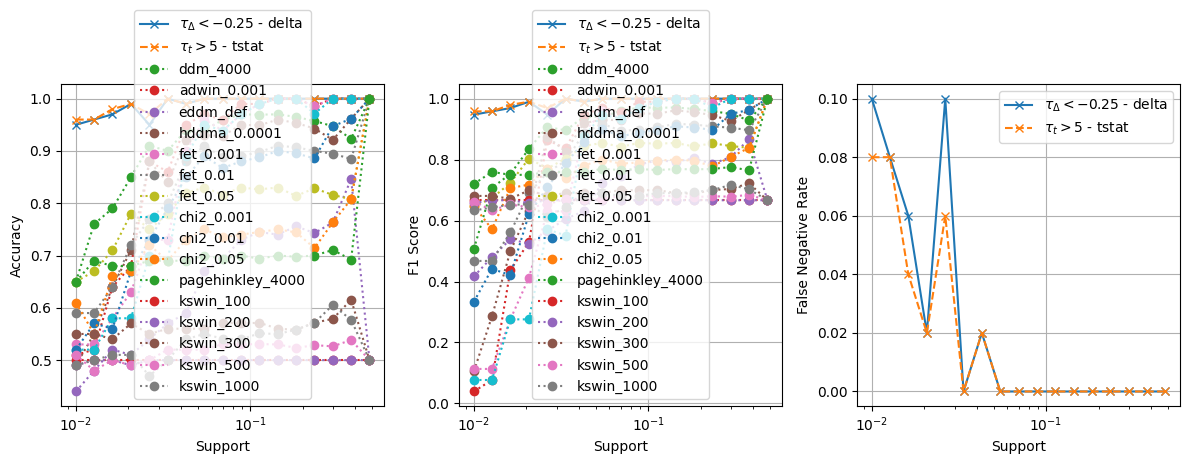

In [132]:
# 2 plots, with extra space for the legend 
fig, ax = plt.subplots(1, 3, figsize=(12, 4))


for k, v in scores_acc["delta"].items():
    ax[0].plot([ b[0] for b in buckets_list ], v, label=f"{k} - delta", marker='x')
    
for k, v in scores_f1["delta"].items():
    ax[1].plot([ b[0] for b in buckets_list ], v, label=f"{k} - delta", marker='x')

for k, v in scores_fnr["delta"].items():
    ax[2].plot([ b[0] for b in buckets_list ], v, label=f"{k} - delta", marker='x')

for k, v in scores_acc["tstat"].items():
    ax[0].plot([ b[0] for b in buckets_list ], v, label=f"{k} - tstat", marker='x', ls='--')
    
for k, v in scores_f1["tstat"].items():
    ax[1].plot([ b[0] for b in buckets_list ], v, label=f"{k} - tstat", marker='x', ls='--')

for k, v in scores_fnr["tstat"].items():
    ax[2].plot([ b[0] for b in buckets_list ], v, label=f"{k} - tstat", marker='x', ls='--')


models = summary["accuracies"].keys()
for model in models:
    ax[0].plot([ s[0] for s in summary["supports"]], summary["accuracies"][model], label=model, ls=':', marker='o')
    ax[1].plot([ s[0] for s in summary["supports"]], summary["f1s"][model], label=model, ls=':', marker='o')
    # ax[2].plot([ s[0] for s in summary["supports"]], summary["fprs"][model], label=model, ls=':', marker='o')

# ax[0].legend()
ax[0].set_xlabel("Support")
ax[0].set_ylabel("Accuracy")
ax[0].grid()

# ax[1].legend()
ax[1].set_xlabel("Support")
ax[1].set_ylabel("F1 Score")
ax[1].grid()

ax[2].set_xlabel("Support")
ax[2].set_ylabel("False Negative Rate")
ax[2].grid()

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")

plt.tight_layout()
# show legend of figure
ax[0].legend()
ax[1].legend()
ax[2].legend()



In [133]:
models_list = [("ddm_4000", "DDM($W=4000$)"),
          ("hddma_0.0001", "HDDM($\epsilon=10^{-4}$)"),
          ("adwin_0.001", "ADWIN($\delta=10^{-3}$)"),
          ("fet_0.01", "FET ($p = 0.01$)"),
          ("chi2_0.01", r"$\chi^2$ ($p = 0.01$)"),
          ("kswin_100", "KSWIN(W=100)") if exp_type == "adult" else ("kswin_300", "KSWIN(W=300)"),
        #   ("kswin_300", "KSWIN(W=300)"), # if exp_type == "adult" else ("kswin_300", "KSWIN(W=300)"),
          ("pagehinkley_4000", "Page-Hinkley($\lambda$=4000)"),]

<>:2: DeprecationWarning: invalid escape sequence '\e'
<>:3: DeprecationWarning: invalid escape sequence '\d'
<>:8: DeprecationWarning: invalid escape sequence '\l'
<>:2: DeprecationWarning: invalid escape sequence '\e'
<>:3: DeprecationWarning: invalid escape sequence '\d'
<>:8: DeprecationWarning: invalid escape sequence '\l'
/tmp/ipykernel_3894221/256972504.py:2: DeprecationWarning: invalid escape sequence '\e'
  ("hddma_0.0001", "HDDM($\epsilon=10^{-4}$)"),
/tmp/ipykernel_3894221/256972504.py:3: DeprecationWarning: invalid escape sequence '\d'
  ("adwin_0.001", "ADWIN($\delta=10^{-3}$)"),
/tmp/ipykernel_3894221/256972504.py:8: DeprecationWarning: invalid escape sequence '\l'
  ("pagehinkley_4000", "Page-Hinkley($\lambda$=4000)"),]


In [134]:
import numpy as np

n_pts = 3

n_models = len(models_list)
metrics = ['accuracies', 'f1s', 'fprs', 'fnrs']
res = np.zeros((n_models * n_pts, len(metrics)))
for k in range(n_pts):
    for i, (model, legend) in enumerate(models_list):
        for j,met in enumerate(metrics):
            res[k * n_models + i,j] = summary[met][model][k]

    res[n_models-1 + n_models*k, 0] = scores_acc["tstat"][rf'$\tau_t > {tau_t}$'][k]
    res[n_models-1 + n_models*k, 1] = scores_f1["tstat"] [rf'$\tau_t > {tau_t}$'][k]
    res[n_models-1 + n_models*k, 2] = scores_fpr["tstat"][rf'$\tau_t > {tau_t}$'][k]
    res[n_models-1 + n_models*k, 3] = scores_fnr["tstat"][rf'$\tau_t > {tau_t}$'][k]

In [135]:
import pandas as pd
from itertools import chain

sups = [0.01, 0.0127, 0.0162]
# index = [list(chain(*[ [v] * (n_models+1) for v in sups])), ([m[1] for m in models_list] + ['DriftInspector'])*len(sups)]
index = [list(chain(*[ [v] * (n_models) for v in sups])), ([m[1] for m in models_list])*len(sups)]
df = pd.DataFrame(res, columns=["Accuracy", "F1 score", "FPR", "FNR"], index=index)

In [136]:
print(df.to_markdown())

|                                           |   Accuracy |   F1 score |   FPR |   FNR |
|:------------------------------------------|-----------:|-----------:|------:|------:|
| (0.01, 'DDM($W=4000$)')                   |       0.65 |  0.507042  |  0.06 |  0.64 |
| (0.01, 'HDDM($\\epsilon=10^{-4}$)')       |       0.49 |  0.105263  |  0.08 |  0.94 |
| (0.01, 'ADWIN($\\delta=10^{-3}$)')        |       0.51 |  0.0392157 |  0    |  0.98 |
| (0.01, 'FET ($p = 0.01$)')                |       0.59 |  0.467532  |  0.18 |  0.64 |
| (0.01, '$\\chi^2$ ($p = 0.01$)')          |       0.52 |  0.333333  |  0.2  |  0.76 |
| (0.01, 'KSWIN(W=300)')                    |       0.55 |  0.680851  |  0.86 |  0.04 |
| (0.01, 'Page-Hinkley($\\lambda$=4000)')   |       0.96 |  0.958333  |  0    |  0.08 |
| (0.0127, 'DDM($W=4000$)')                 |       0.76 |  0.707317  |  0.06 |  0.42 |
| (0.0127, 'HDDM($\\epsilon=10^{-4}$)')     |       0.55 |  0.285714  |  0.08 |  0.82 |
| (0.0127, 'ADWIN($\\delta=10^{-

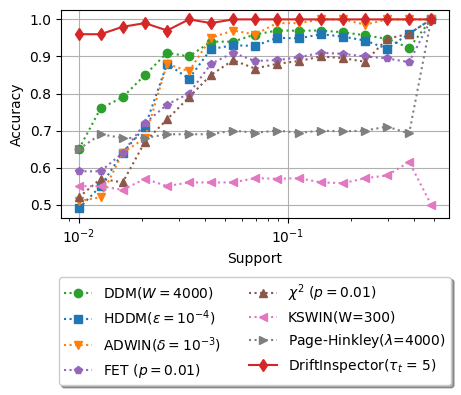

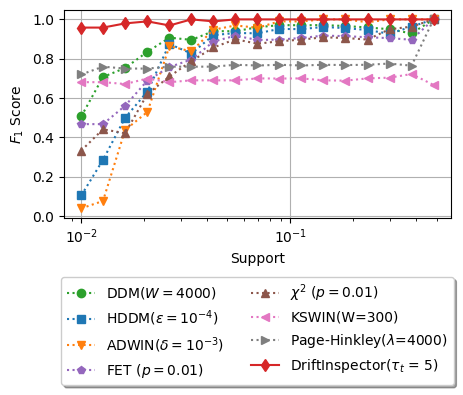

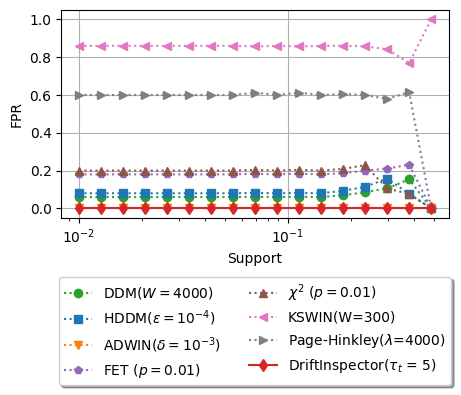

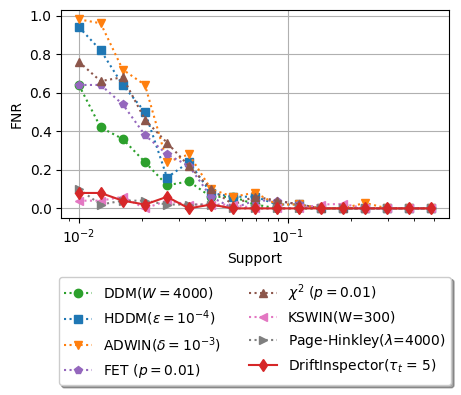

In [137]:
# 2 plots, with extra space for the legend 
# fig, ax = plt.subplots(2,1, figsize=(4.5,5.))
# plt.tight_layout()
# fig0, ax0 = plt.subplots(figsize=(5, 2.2)) # original
# fig1, ax1 = plt.subplots(figsize=(5, 2.2))
fig0, ax0 = plt.subplots(figsize=(5, 2.7))
fig1, ax1 = plt.subplots(figsize=(5, 2.7))
fig2, ax2 = plt.subplots(figsize=(5, 2.7))
fig3, ax3 = plt.subplots(figsize=(5, 2.7))

models = summary["accuracies"].keys()
markers = ['d', 'o', 's', 'v', 'p', '^', '<', '>', 'p', 'h']
colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

drift_delta_label = rf"DriftInspector ($\tau_\Delta$ = {tau_delta})"
drift_t_label = fr"DriftInspector($\tau_t$ = {tau_t})"

# include = ["t", "delta"]
include = ["t"]


# for i, (model, legend) in enumerate([("dmm_4000", "DMM($W=4000$)"), ("adwin_0.004", "ADWIN($\delta=0.004$)")]):
# models_list = [("dmm_4000", "DDM($W=4000$)"),
#           ("hddm_a_0.0001", "HDDM($\epsilon=10^{-4}$)"),
#           ("adwin_0.001", "ADWIN($\delta=10^{-3}$)"),
#           ("fet", "Fisher"),
#           ("chi2", r"$\chi^2$")]
for i, (model, legend) in enumerate(models_list):
    ax0.plot([ s[0] for s in summary["supports"]], summary["accuracies"][model], label=legend, ls=':', marker=markers[len(include)+i], color=colors[i+len(include)])
    ax1.plot([ s[0] for s in summary["supports"]], summary["f1s"][model], label=legend, ls=':',        marker=markers[len(include)+i], color=colors[i+len(include)])
    ax2.plot([ s[0] for s in summary["supports"]], summary["fprs"][model], label=legend, ls=':',       marker=markers[len(include)+i], color=colors[i+len(include)])
    ax3.plot([ s[0] for s in summary["supports"]], summary["fnrs"][model], label=legend, ls=':',       marker=markers[len(include)+i], color=colors[i+len(include)])

if "delta" in include:
    ax0.plot([ b[0] for b in buckets_list ], scores_acc["delta"][rf'$\tau_\Delta < {tau_delta}$'], label=drift_delta_label, marker=markers[0], color=colors[0])
    ax1.plot([ b[0] for b in buckets_list ], scores_f1["delta"][rf'$\tau_\Delta < {tau_delta}$'], label=drift_delta_label, marker=markers[0], color=colors[0])
    ax2.plot([ b[0] for b in buckets_list ], scores_fpr["delta"][rf'$\tau_\Delta < {tau_delta}$'], label=drift_delta_label, marker=markers[0], color=colors[0])
    ax3.plot([ b[0] for b in buckets_list ], scores_fnr["delta"][rf'$\tau_\Delta < {tau_delta}$'], label=drift_delta_label, marker=markers[0], color=colors[0])

if "t" in include:
    pos = int("delta" in include)
    ax0.plot([ b[0] for b in buckets_list ], scores_acc["tstat"][rf'$\tau_t > {tau_t}$'], label=drift_t_label, marker=markers[pos], color=colors[pos])
    ax1.plot([ b[0] for b in buckets_list ], scores_f1["tstat"] [rf'$\tau_t > {tau_t}$'], label=drift_t_label, marker=markers[pos], color=colors[pos])
    ax2.plot([ b[0] for b in buckets_list ], scores_fpr["tstat"][rf'$\tau_t > {tau_t}$'], label=drift_t_label, marker=markers[pos], color=colors[pos])
    ax3.plot([ b[0] for b in buckets_list ], scores_fnr["tstat"][rf'$\tau_t > {tau_t}$'], label=drift_t_label, marker=markers[pos], color=colors[pos])
    


# ax[0].legend()
ax0.set_xlabel("Support")
ax0.set_ylabel("Accuracy")
ax0.grid()

# ax[1].legend()
ax1.set_xlabel("Support")
ax1.set_ylabel("$F_1$ Score")
ax1.grid()

ax2.set_xlabel("Support")
ax2.set_ylabel("FPR")
ax2.grid()

ax3.set_xlabel("Support")
ax3.set_ylabel("FNR")
ax3.grid()

ax0.set_xscale("log")
ax1.set_xscale("log")
ax2.set_xscale("log")
ax3.set_xscale("log")

# show legend of figure
# legend at top of each ax
# ax0.legend(, ncol=3)
ax0.legend(loc="upper center" , ncol=2, bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True)
ax1.legend(loc="upper center" , ncol=2, bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True)
ax2.legend(loc="upper center" , ncol=2, bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True)
ax3.legend(loc="upper center" , ncol=2, bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True)

# ax0.legend(bbox_to_anchor=(1, 1))
# ax1.legend(bbox_to_anchor=(1, 1))
# ax2.legend(bbox_to_anchor=(1, 1))
# ax3.legend(bbox_to_anchor=(1, 1))

fig0.savefig(f"overall-detection-acc-{exp_type}.pdf", bbox_inches='tight')
fig1.savefig(f"overall-detection-f1-{exp_type}.pdf", bbox_inches='tight')

In [149]:
import pandas as pd

dataset_name = {"adult": "Adult", "celeba": "CelebA"}[exp_type]

acc_tstat_list = [ accuracy_score(y_true, y_pred) for y_true, y_pred in zip(y_trues["tstat"], y_preds["tstat"]) ]
f1_tstat_list = [ f1_score(y_true, y_pred) for y_true, y_pred in zip(y_trues["tstat"], y_preds["tstat"]) ]
fpr_tstat_list = [ (confusion_matrix(y_true, y_pred).ravel()[1] / (confusion_matrix(y_true, y_pred).ravel()[1] + confusion_matrix(y_true, y_pred).ravel()[0])) for y_true, y_pred in zip(y_trues["tstat"], y_preds["tstat"]) ]
fnr_tstat_list = [ (confusion_matrix(y_true, y_pred).ravel()[2] / (confusion_matrix(y_true, y_pred).ravel()[2] + confusion_matrix(y_true, y_pred).ravel()[3])) for y_true, y_pred in zip(y_trues["tstat"], y_preds["tstat"]) ]

data = {
    dataset_name: {
        ("Accuracy", fr"\textsc{{DriftExplorer}} ($\tau_t = 5$)"): f"{np.mean(acc_tstat_list):.3f} pm {np.std(acc_tstat_list):.3f}",
        ("F1 Score", fr"\textsc{{DriftExplorer}} ($\tau_t = 5$)"): f"{np.mean(f1_tstat_list):.3f} pm {np.std(f1_tstat_list):.3f}",
        ("FPR", fr"\textsc{{DriftExplorer}} ($\tau_t = 5$)"): f"{np.mean(fpr_tstat_list):.3f} pm {np.std(fpr_tstat_list):.3f}",
        ("FNR", fr"\textsc{{DriftExplorer}} ($\tau_t = 5$)"): f"{np.mean(fnr_tstat_list):.3f} pm {np.std(fnr_tstat_list):.3f}",
    }
}

metric_policy = ["avg", "block"]

# with open(f"../true_y_pred_results_overall_{exp_type}.pkl", "rb") as f:
with open(f"{basedir_summary}/true_y_pred_results_overall_{exp_type}_may_21.pkl", "rb") as f:
    obj = pickle.load(f)

# for method, method_name in zip(["dmm_4000", "hddm_a_0.0001", "adwin_0.001"], ["DMM($W=4000$)", "HDDM($\epsilon=10^{-4}$)", "ADWIN($\delta=10^{-3}$)"]):
for method, method_name in models_list:
    if "page" in method:
        print(confusion_matrix(np.hstack(v["y_true"] for v in obj_results.values()), np.hstack([v["y_pred_raw"] for v in obj_results.values()])>=1))
        continue
    obj_results = { k: v for k, v in obj[method].items() if k[0] < sup_thresh }
    acc_list = [ accuracy_score(v["y_true"], np.array(v["y_pred_raw"])>=1) for v in obj_results.values() ]
    f1_list = [ f1_score(v["y_true"], np.array(v["y_pred_raw"])>=1) for v in obj_results.values() ]
    fpr_list = [ (confusion_matrix(v["y_true"], np.array(v["y_pred_raw"])>=1).ravel()[1] / (confusion_matrix(v["y_true"], np.array(v["y_pred_raw"])>=1).ravel()[1] + confusion_matrix(v["y_true"], np.array(v["y_pred_raw"])>=1).ravel()[0])) for v in obj_results.values() ]
    fnr_list = [ (confusion_matrix(v["y_true"], np.array(v["y_pred_raw"])>=1).ravel()[2] / (confusion_matrix(v["y_true"], np.array(v["y_pred_raw"])>=1).ravel()[2] + confusion_matrix(v["y_true"], np.array(v["y_pred_raw"])>=1).ravel()[3])) for v in obj_results.values() ]
    
    if "adwin" in method:
        print(fnr_list, fpr_list)
    data[dataset_name][("Accuracy", f"{method_name}")] = f"{np.mean(acc_list):.3f} pm {np.std(acc_list):.3f}"
    data[dataset_name][("F1 Score", f"{method_name}")] = f"{np.mean(f1_list):.3f} pm {np.std(f1_list):.3f}"
    data[dataset_name][("FPR", f"{method_name}")] = f"{np.mean(fpr_list):.3f} pm {np.std(fpr_list):.3f}"
    data[dataset_name][("FNR", f"{method_name}")] = f"{np.mean(fnr_list):.3f} pm {np.std(fnr_list):.3f}"

# print(pd.DataFrame(data).sort_index().to_latex())
print(pd.DataFrame(data).sort_index())

[0.98, 0.96, 0.72, 0.64, 0.24, 0.28, 0.1, 0.06, 0.08163265306122448, 0.02, 0.02040816326530612, 0.0, 0.0, 0.02857142857142857, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[[101 608]
 [ 14 695]]
                                                        CelebA
Accuracy $\chi^2$ ($p = 0.01$)                  0.812 pm 0.144
         ADWIN($\delta=10^{-3}$)                0.879 pm 0.170
         DDM($W=4000$)                          0.906 pm 0.090
         FET ($p = 0.01$)                       0.828 pm 0.119
         HDDM($\epsilon=10^{-4}$)               0.854 pm 0.152
         KSWIN(W=300)                           0.561 pm 0.022
         \textsc{DriftExplorer} ($\tau_t = 5$)  0.991 pm 0.014
F1 Score $\chi^2$ ($p = 0.01$)                  0.786 pm 0.201
         ADWIN($\delta=10^{-3}$)                0.801 pm 0.316
         DDM($W=4000$)                          0.892 pm 0.123
         FET ($p = 0.01$)                       0.811 pm

/tmp/ipykernel_3894221/1157016077.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  print(confusion_matrix(np.hstack(v["y_true"] for v in obj_results.values()), np.hstack([v["y_pred_raw"] for v in obj_results.values()])>=1))


(0.01, 0.0127) => 1
(0.0127, 0.0162) => 1
(0.0162, 0.0207) => 1
(0.0207, 0.0264) => 1
(0.0264, 0.0336) => 1
(0.0336, 0.0428) => 1
(0.0428, 0.0546) => 2
(0.0546, 0.0695) => 2
(0.0695, 0.0886) => 2
(0.0886, 0.1129) => 2
(0.1129, 0.1438) => 4
(0.1438, 0.1833) => 1
(0.1833, 0.2336) => 4
(0.2336, 0.2976) => 3
(0.2976, 0.3793) => 7
(0.3793, 0.4833) => 6
(0.4833, 0.6158) => 8
(0.6158, 0.7848) => 11
(0.7848, 1.0) => 16


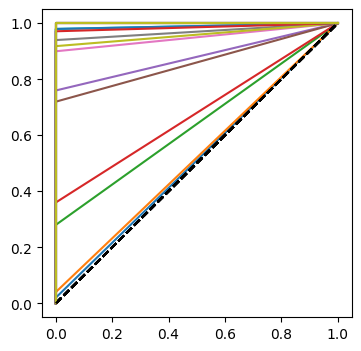

In [139]:
method = "adwin_0.001"
raw_scores_oth = { k: (v["y_true"], v["y_pred_raw"]) for k, v in obj[method].items() }
from sklearn.metrics import roc_auc_score
fig, ax = plt.subplots(figsize=(4,4))
# roc curves
from sklearn.metrics import roc_curve

aucs = {}
best_thresh = {}
aucs = []
best_thresh = []
buckets_list = sorted(raw_scores_oth.keys(), key=lambda x: x[0])
for bucket_pos, bucket in enumerate(buckets_list):
    y, X = raw_scores_oth[bucket]

    fpr, tpr, thresh = roc_curve(y, X)
    auc = roc_auc_score(y, X)
    aucs.append(auc)
    
    j_statistic = tpr - fpr
    optimal_threshold_index = np.argmax(j_statistic)
    # [bucket_pos // 4, bucket_pos % 4]
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], c='k', ls='--')
    # ax.set_xticks([])
    # ax.set_yticks([])
    best_thresh.append(thresh[optimal_threshold_index])
    print(bucket, "=>", thresh[optimal_threshold_index])

In [140]:
import pandas as pd

In [141]:
import glob
import pickle

with open(glob.glob("../../models-ckpt/sup-wise/*.pkl")[0], "rb") as f:
    obj = pickle.load(f)

In [142]:
# load celeba
from torchvision.datasets import CelebA

ds = CelebA(root="../../data", split="all", target_type="identity", download=False)

In [143]:

data = {
    "Adult": {
        "Samples": 48842,
        "Type": "Tabular",
        "Descriptive features": 14,
        "Feature type": "categorical, continuous (binned)",
        "# Subgroups (minsup = 0.01)": 192099,
        "Binary target": r"Income $\ge$ 50K? y/n",
    },
    "CelebA": {
        "Samples": 202599,
        "Type": "Images + annotations",
        "Descriptive features": 39,
        "Feature type": "binary",
        "# Subgroups (minsup = 0.01)": 26597,
        "Binary target": "Attractive? y/n"
    }
}

df = pd.DataFrame(data)
print(df.to_latex())

\begin{tabular}{lll}
\toprule
 & Adult & CelebA \\
\midrule
Samples & 48842 & 202599 \\
Type & Tabular & Images + annotations \\
Descriptive features & 14 & 39 \\
Feature type & categorical, continuous (binned) & binary \\
# Subgroups (minsup = 0.01) & 192099 & 26597 \\
Binary target & Income $\ge$ 50K? y/n & Attractive? y/n \\
\bottomrule
\end{tabular}



In [144]:
    
def load_adult_df():
    columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","target"]
    categ = ["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]
    num = [ c for c in columns if c not in categ and c != "target" ]
    df = pd.concat([pd.read_csv(os.path.join(data_dir, "adult.data"), header=None, index_col=False), pd.read_csv(os.path.join(data_dir, "adult.test"), header=None, index_col=False, skiprows=1)], axis=0)
    df.columns = columns
    df["target"] = df["target"].apply(lambda x: 1 if x in [" >50K", ">50K."] else 0)
    return df, categ, num

df = load_adult_df()

In [145]:
df, categ, num = load_adult_df()

In [146]:
df.target.mean()

0.16053806150444289

<>:20: DeprecationWarning: invalid escape sequence '\D'
<>:20: DeprecationWarning: invalid escape sequence '\D'
/tmp/ipykernel_3894221/162012252.py:20: DeprecationWarning: invalid escape sequence '\D'
  ax1.plot([ b[0] for b in buckets_list_adult ][:-2], [ -d for d in best_thresh_adult["delta"]][:-2], c='tab:green',ls ='--',label="min $\Delta_{acc}$")


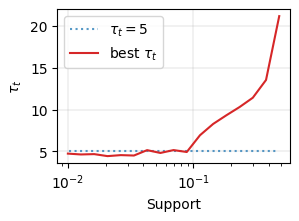

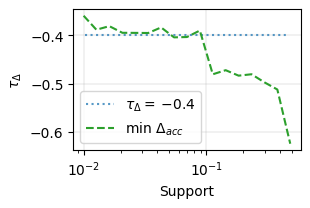

In [147]:
fig0, ax0 = plt.subplots(figsize=(3, 2))
fig1, ax1 = plt.subplots(figsize=(3, 2))
# tight layout
plt.tight_layout()

tau_t = 5

ax0.axhline(tau_t, 0.05, 0.95, c='tab:blue', alpha=.75, ls=':', label=rf"$\tau_{{t}} = 5$")
ax1.axhline(-0.4,  0.05, 0.95, c='tab:blue',  alpha=.75,ls=':', label=rf"$\tau_{{\Delta}} = -\!0.4$")
# ax1.axhline(-0.25, 0.05, 0.95, c='tab:blue', alpha=.75, ls='--', label=rf"$\tau_{{\Delta,C}} = -\!0.25$")

with open("best_thresh_adult.pkl", "rb") as f:
    best_thresh_adult, buckets_list_adult = pickle.load(f)
with open("best_thresh_celeba.pkl", "rb") as f:
    best_thresh_celeba, buckets_list_celeba = pickle.load(f)

ax0.plot([ b[0] for b in buckets_list_adult ][:-2], best_thresh_adult["tstat"][:-2], c='tab:red',label=r"best $\tau_t$")
# ax0.plot([ b[0] for b in buckets_list_celeba ], best_thresh_celeba["tstat"], c='tab:red',ls ='--', label="CelebA")

ax1.plot([ b[0] for b in buckets_list_adult ][:-2], [ -d for d in best_thresh_adult["delta"]][:-2], c='tab:green',ls ='--',label="min $\Delta_{acc}$")
# ax1.plot([ b[0] for b in buckets_list_celeba ], [ -d for d in best_thresh_celeba["delta"]], c='tab:green',ls ='--', label="CelebA")

ax0.set_ylabel(r"$\tau_{t}$")
ax1.set_ylabel(r"$\tau_{\Delta}$")

# rotate y labels
# for ax in [ax0, ax1]:
#     ax.tick_params(axis='y', rotation=90)

for ax in [ax0, ax1]:
    ax.grid(linewidth=.25)
    ax.set_xscale("log")
    ax.legend()
    ax.set_xlabel("Support")

# ax0.set_ylim([0, 75])
# ax0.set_yticks([10, 30, 50, 70])

fig0.savefig(f"tau-t-vs-sup.pdf", bbox_inches='tight')
fig1.savefig(f"tau-delta-vs-sup.pdf", bbox_inches='tight')